## **Experiment 3** Validation Set Partition (Model Comparison)

**실험 목적:** 
보통 AI 모델 훈련에서는 data set이 train/validation/test 세 가지로 구분되어 사용된다. 하지만 기존 코드는 성능 검증 단계에서 test data set을 반복적으로 사용하며, 이는 모델이 overfittng될 가능성을 초래한다. 따라서 이번 실험에서는 원래의 코드에 train data set의 일부를 validation data set으로 분리하는 코드를 추가한다. 하이퍼파라미터 튜닝과 같은 훈련 중 검증은 validation data set으로 수행하고, test data set은 최종 성능 평가에만 단 1회 사용될 수 있도록 하여 최종 성능을 비교한다.


- 모든 실험 코드는 ml-mnist.ipynb를 토대로 수정하였습니다.
- 실험 과정 중 생성형AI(Gemini)의 도움을 받은 부분은 (by Gemini)로 표기하였습니다.

#### 1. 라이브러리 임포트 및 랜덤 시드 값 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random

# --- 실험의 Reproductibility를 확보하기 위해 랜덤 시드(Random Seed) 설정 --- (by Gemini)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# ------------------------------------

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

PyTorch version: 2.8.0+cpu
CUDA available: False
Using CPU


#### 2. MLP(Multi-Layer Perceptron) 모델 정의

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=100, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # 784 -> 100
            nn.ReLU(),                          # 활성화 함수
            nn.Linear(hidden_size, num_classes) # 100 -> 10
        )
    
    def forward(self, x):
        """
        순전파 함수 // forward propagation
        x: 입력 텐서 (batch_size, 784)
        return: 출력 텐서 (batch_size, 10)
        """
        return self.layers(x)

# 모델 생성 및 구조 확인
model = MLP()
print("모델 구조:")
print(model)

# 파라미터 개수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n총 파라미터 수: {total_params:,}")
print(f"학습 가능한 파라미터 수: {trainable_params:,}")

# 각 레이어별 파라미터 수 확인
print("\n레이어별 파라미터:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} ({param.numel():,} 개)")

모델 구조:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

총 파라미터 수: 79,510
학습 가능한 파라미터 수: 79,510

레이어별 파라미터:
layers.0.weight: torch.Size([100, 784]) (78,400 개)
layers.0.bias: torch.Size([100]) (100 개)
layers.2.weight: torch.Size([10, 100]) (1,000 개)
layers.2.bias: torch.Size([10]) (10 개)


#### 3. 데이터 로딩 및 전처리
3-1. 하이퍼파라미터 설정

In [3]:
# 하이퍼파라미터 설정
batch_size = 128        # 배치 크기
test_batch_size = 1000  # 테스트 배치 크기 (메모리 효율을 위해 크게 설정)
learning_rate = 1e-3    # 학습률 (0.001)
nb_epochs = 6           # 에포크 수

print("=== 하이퍼파라미터 ===")
print(f"배치 크기: {batch_size}")
print(f"테스트 배치 크기: {test_batch_size}")
print(f"학습률: {learning_rate}")
print(f"에포크 수: {nb_epochs}")

# 디바이스 설정 (GPU가 있으면 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n사용 디바이스: {device}")
if device.type == "cuda":
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

=== 하이퍼파라미터 ===
배치 크기: 128
테스트 배치 크기: 1000
학습률: 0.001
에포크 수: 6

사용 디바이스: cpu


3-2. MNIST 데이터셋 로딩

In [4]:
# --- 3-2. MNIST 데이터셋 로딩 및 분할 (by Gemini) ---

# MNIST 데이터셋 로딩
print("MNIST 데이터셋을 다운로드 중...")
mnist = load_dataset("mnist")

# 훈련 데이터셋을 훈련용과 검증용으로 분할
train_valid_split = mnist['train'].train_test_split(test_size=1/6, seed=SEED)
train_dataset_raw = train_valid_split['train']
valid_dataset_raw = train_valid_split['test']
test_dataset_raw = mnist['test']

# 데이터셋 정보 출력
print("\n=== 데이터셋 정보 ===")
print(f"훈련 데이터: {len(train_dataset_raw):,}개")
print(f"검증 데이터: {len(valid_dataset_raw):,}개")
print(f"테스트 데이터: {len(test_dataset_raw):,}개")
print(f"클래스 수: {len(set(train_dataset_raw['label']))}개 (0-9)")
print(f"이미지 크기: {train_dataset_raw[0]['image'].size}")

# 샘플 이미지 확인
sample_image = train_dataset_raw[0]['image']
sample_label = train_dataset_raw[0]['label']
print(f"\n첫 번째 샘플: 라벨 {sample_label}")

MNIST 데이터셋을 다운로드 중...

=== 데이터셋 정보 ===
훈련 데이터: 50,000개
검증 데이터: 10,000개
테스트 데이터: 10,000개
클래스 수: 10개 (0-9)
이미지 크기: (28, 28)

첫 번째 샘플: 라벨 7


3-3. 데이터 정규화

In [5]:
# 데이터셋의 평균과 표준편차 계산 (1000개 샘플로 추정)
print("데이터셋의 통계 정보를 계산 중...")
sample_data = torch.stack([
    transforms.ToTensor()(mnist['train'][i]['image']) 
    for i in range(1000)
])

mean = sample_data.mean().item()
std = sample_data.std().item()
print(f"평균(mean): {mean:.4f}")
print(f"표준편차(std): {std:.4f}")

# Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),           # PIL Image -> Tensor, 0-255 -> 0-1
    transforms.Normalize((mean,), (std,))  # 정규화
])

print("\n변환 파이프라인:")
print("1. ToTensor(): PIL Image -> PyTorch Tensor (0-255 -> 0-1)")
print(f"2. Normalize(): (픽셀값 - {mean:.4f}) / {std:.4f}")

# 변환 전후 비교
original_pixel = mnist['train'][0]['image']
transformed = transform(original_pixel)
print(f"\n변환 예시:")
print(f"원본 픽셀 범위: 0-255")
print(f"ToTensor 후: 0-1")
print(f"정규화 후 범위: 약 {transformed.min():.2f} ~ {transformed.max():.2f}")

데이터셋의 통계 정보를 계산 중...
평균(mean): 0.1282
표준편차(std): 0.3051

변환 파이프라인:
1. ToTensor(): PIL Image -> PyTorch Tensor (0-255 -> 0-1)
2. Normalize(): (픽셀값 - 0.1282) / 0.3051

변환 예시:
원본 픽셀 범위: 0-255
ToTensor 후: 0-1
정규화 후 범위: 약 -0.42 ~ 2.86


3-4. Data Loader 생성

In [6]:
# --- 3-4. Data Loader 생성 (by Gemini) ---

# 데이터 변환 함수 정의
def transform_dataset(dataset):
    """데이터셋에 변환을 적용하는 함수"""
    def transform_fn(batch):
        # 이미지를 텐서로 변환하고 28x28을 784로 평탄화
        images = [transform(img).view(-1) for img in batch["image"]]
        return {
            "image": torch.stack(images),
            "label": torch.tensor(batch["label"])
        }
    return dataset.with_transform(transform_fn)

# 훈련/검증/테스트 데이터셋에 변환 적용
print("데이터셋 변환 중...")
train_dataset = transform_dataset(train_dataset_raw)
valid_dataset = transform_dataset(valid_dataset_raw) # 검증 데이터셋 추가
test_dataset = transform_dataset(test_dataset_raw)

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
# 검증 DataLoader 추가
valid_loader = DataLoader(
    valid_dataset,
    batch_size=test_batch_size, # 테스트와 동일한 배치 크기 사용
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

print(f"\n훈련 DataLoader: {len(train_loader)}개 배치")
print(f"검증 DataLoader: {len(valid_loader)}개 배치") # 검증 로더 정보 추가
print(f"테스트 DataLoader: {len(test_loader)}개 배치")

# 첫 번째 배치 확인
sample_batch = next(iter(train_loader))
print(f"\n첫 번째 배치 shape:")
print(f"이미지: {sample_batch['image'].shape}  # (batch_size, 784)")
print(f"라벨: {sample_batch['label'].shape}    # (batch_size,)")

데이터셋 변환 중...

훈련 DataLoader: 391개 배치
검증 DataLoader: 10개 배치
테스트 DataLoader: 10개 배치

첫 번째 배치 shape:
이미지: torch.Size([128, 784])  # (batch_size, 784)
라벨: torch.Size([128])    # (batch_size,)


#### 4. 모델 훈련
4-1. 모델, 손실함수, 최적화기 설정

In [7]:
# 모델 초기화 
model = MLP().to(device)  # 모델을 GPU로 이동 (있다면)

# 손실함수: 다중 클래스 분류를 위한 CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 최적화기: Adam (적응적 학습률 알고리즘)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("=== 훈련 설정 ===")
print(f"모델: {model.__class__.__name__}")
print(f"손실함수: {criterion.__class__.__name__}")
print(f"최적화기: {optimizer.__class__.__name__}")
print(f"디바이스: {device}")
print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}개")

# 훈련 설정 요약
print(f"\n=== 훈련 정보 ===")
print(f"전체 에포크: {nb_epochs}")
print(f"배치 크기: {batch_size}")
print(f"학습률: {learning_rate}")
print(f"에포크당 배치 수: {len(train_loader)}")
print(f"에포크당 훈련 샘플 수: {len(train_loader) * batch_size:,}")
print(f"전체 훈련 스텝: {nb_epochs * len(train_loader):,}")

=== 훈련 설정 ===
모델: MLP
손실함수: CrossEntropyLoss
최적화기: Adam
디바이스: cpu
모델 파라미터 수: 79,510개

=== 훈련 정보 ===
전체 에포크: 6
배치 크기: 128
학습률: 0.001
에포크당 배치 수: 391
에포크당 훈련 샘플 수: 50,048
전체 훈련 스텝: 2,346


4-2. 훈련 루프 실행

In [8]:
# --- 4-2. 훈련 루프 실행 (Validation 단계 추가 by Gemini) ---
import time

# 훈련 과정 추적을 위한 리스트
train_losses = []
train_accuracies = []
valid_accuracies = [] # 검증 정확도 리스트 추가
test_accuracies = []

print("=== 훈련 시작 ===\n")
start_time = time.time()

for epoch in range(nb_epochs):
    # --- 훈련 단계 ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, batch in enumerate(train_loader):
        imgs, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)

    print(f"Epoch [{epoch+1}/{nb_epochs}] 훈련 완료:")
    print(f"  평균 Loss: {epoch_loss:.4f}, 훈련 정확도: {epoch_train_acc:.2f}%")

    # --- 검증 단계 ---
    model.eval()
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for batch in valid_loader:
            imgs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_acc = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_acc)
    print(f"  검증 정확도: {valid_acc:.2f}%") # 검증 정확도 출력
    print("-" * 60)

# --- 최종 테스트 ---
# (모든 훈련이 끝난 후, 최종 모델의 성능을 딱 한 번만 평가)
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for batch in test_loader:
        imgs, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_acc = 100 * correct_test / total_test
test_accuracies.append(test_acc) # 최종 테스트 결과 저장

end_time = time.time()
training_time = end_time - start_time
mins, secs = int(training_time // 60), int(training_time % 60)

print(f"\n=== 훈련 완료 ===")
print(f"총 훈련 시간: {mins}분 {secs}초 ({training_time:.2f}초)")
print(f"최종 훈련 정확도: {train_accuracies[-1]:.2f}%")
print(f"최고 검증 정확도: {max(valid_accuracies):.2f}% (Epoch {np.argmax(valid_accuracies) + 1})")
print(f"최종 테스트 정확도: {test_accuracies[-1]:.2f}%")

=== 훈련 시작 ===

Epoch [1/6] 훈련 완료:
  평균 Loss: 0.3322, 훈련 정확도: 90.54%
  검증 정확도: 94.24%
------------------------------------------------------------
Epoch [2/6] 훈련 완료:
  평균 Loss: 0.1509, 훈련 정확도: 95.56%
  검증 정확도: 95.86%
------------------------------------------------------------
Epoch [3/6] 훈련 완료:
  평균 Loss: 0.1092, 훈련 정확도: 96.84%
  검증 정확도: 96.57%
------------------------------------------------------------
Epoch [4/6] 훈련 완료:
  평균 Loss: 0.0838, 훈련 정확도: 97.50%
  검증 정확도: 96.98%
------------------------------------------------------------
Epoch [5/6] 훈련 완료:
  평균 Loss: 0.0694, 훈련 정확도: 97.96%
  검증 정확도: 96.86%
------------------------------------------------------------
Epoch [6/6] 훈련 완료:
  평균 Loss: 0.0573, 훈련 정확도: 98.25%
  검증 정확도: 97.22%
------------------------------------------------------------

=== 훈련 완료 ===
총 훈련 시간: 1분 20초 (80.17초)
최종 훈련 정확도: 98.25%
최고 검증 정확도: 97.22% (Epoch 6)
최종 테스트 정확도: 97.21%


#### 5. 결과 분석 및 시각화
5-1. 훈련 과정 시각화

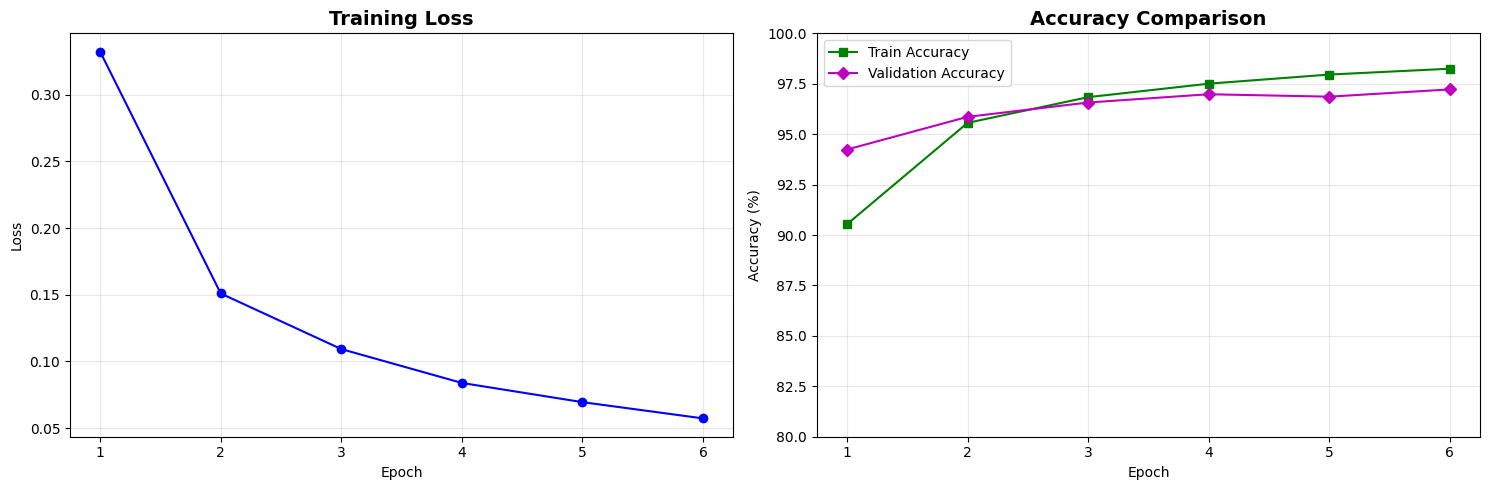

=== 최종 결과 요약 ===
최종 훈련 Loss: 0.0573
최종 훈련 정확도: 98.25%
최고 검증 정확도: 97.22% (Epoch 6)
최종 테스트 정확도: 97.21%


In [9]:
# --- 5-1. 훈련 과정 시각화 (Validation 결과 추가 by Gemini) ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 그래프
epochs_range = range(1, nb_epochs + 1)
ax1.plot(epochs_range, train_losses, 'b-', marker='o', label='Training Loss')
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'), ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3), ax1.set_xticks(epochs_range)

# 정확도 그래프
ax2.plot(epochs_range, train_accuracies, 'g-', marker='s', label='Train Accuracy')
ax2.plot(epochs_range, valid_accuracies, 'm-', marker='D', label='Validation Accuracy') # 검증 정확도 추가
ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'), ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3), ax2.legend(), ax2.set_xticks(epochs_range)
ax2.set_ylim(80, 100) # y축 범위 설정

plt.tight_layout()
plt.show()

# 최종 결과 요약
print("=== 최종 결과 요약 ===")
print(f"최종 훈련 Loss: {train_losses[-1]:.4f}")
print(f"최종 훈련 정확도: {train_accuracies[-1]:.2f}%")
print(f"최고 검증 정확도: {max(valid_accuracies):.2f}% (Epoch {np.argmax(valid_accuracies) + 1})")
print(f"최종 테스트 정확도: {test_accuracies[-1]:.2f}%")

5-2. 예측 결과 시각화

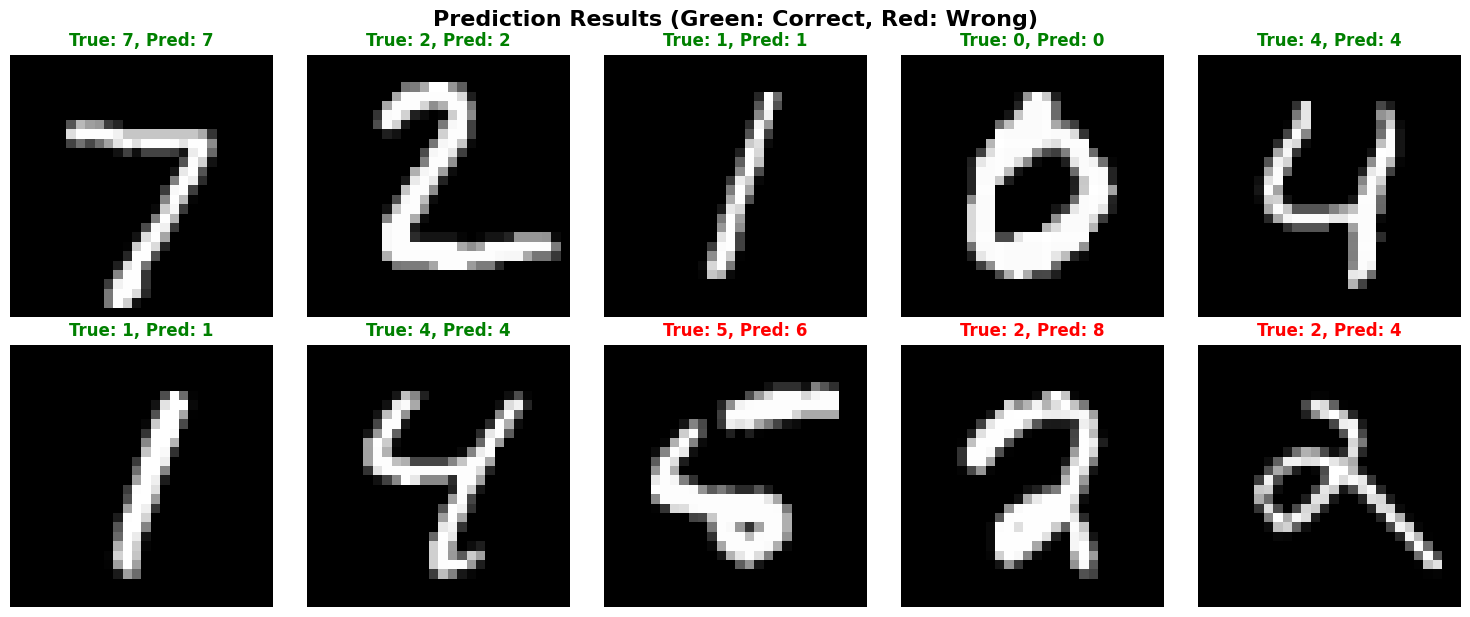

올바른 예측: 7개
틀린 예측: 3개


In [10]:
# 예측 샘플 수집
model.eval()
correct_samples = []
wrong_samples = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        
        # 정확한 예측과 틀린 예측 분리
        for i in range(len(imgs)):
            if len(correct_samples) >= 7 and len(wrong_samples) >= 3:
                break
                
            sample = (imgs[i], labels[i], predicted[i], outputs[i])
            if labels[i] == predicted[i] and len(correct_samples) < 7:
                correct_samples.append(sample)
            elif labels[i] != predicted[i] and len(wrong_samples) < 3:
                wrong_samples.append(sample)
        
        if len(correct_samples) >= 7 and len(wrong_samples) >= 3:
            break

# 시각화: 7개 맞춘 것 + 3개 틀린 것
display_samples = correct_samples + wrong_samples

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (img, true_label, pred_label, output) in enumerate(display_samples):
    # 28x28로 reshape (정규화된 상태)
    img_display = img.cpu().view(28, 28)
    
    # 정규화를 역변환 (시각화를 위해)
    img_display = img_display * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    
    axes[i].imshow(img_display, cmap='gray')
    
    # 색상 설정: 맞으면 초록, 틀리면 빨강
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label.item()}, Pred: {pred_label.item()}', color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Prediction Results (Green: Correct, Red: Wrong)', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print(f"올바른 예측: {len([s for s in display_samples if s[1] == s[2]])}개")
print(f"틀린 예측: {len([s for s in display_samples if s[1] != s[2]])}개")

5-3. 모델의 확신도 분석

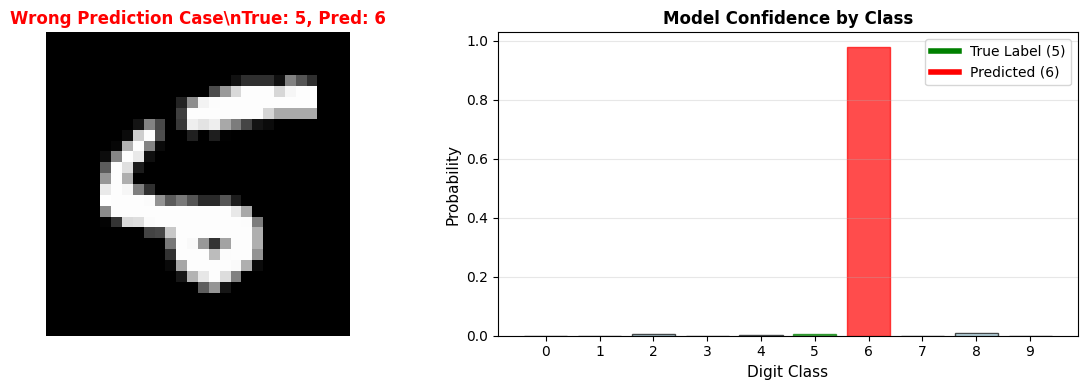

\n=== 모델의 상위 3개 예측 ===
1위: 숫자 6 (확률: 97.94%)
2위: 숫자 8 (확률: 1.01%)
3위: 숫자 2 (확률: 0.50%)
\n실제 라벨 5의 확률: 0.42%


In [11]:
# 틀린 예측에 대한 상세 분석
if wrong_samples:
    wrong_img, wrong_true, wrong_pred, wrong_output = wrong_samples[0]
    
    # 소프트맥스를 통해 확률로 변환
    probabilities = torch.softmax(wrong_output, dim=0).cpu()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 왼쪽: 틀린 예측 이미지
    img_display = wrong_img.cpu().view(28, 28) * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    ax1.imshow(img_display, cmap='gray')
    ax1.set_title(f'Wrong Prediction Case\\nTrue: {wrong_true.item()}, Pred: {wrong_pred.item()}', 
                  color='red', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # 오른쪽: 확률 분포
    bars = ax2.bar(range(10), probabilities, alpha=0.7, color='lightblue', edgecolor='black')
    
    # 실제 라벨과 예측 라벨 강조
    bars[wrong_true.item()].set_color('green')
    bars[wrong_pred.item()].set_color('red')
    
    ax2.set_xlabel('Digit Class', fontsize=11)
    ax2.set_ylabel('Probability', fontsize=11)
    ax2.set_title('Model Confidence by Class', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(10))
    ax2.grid(axis='y', alpha=0.3)
    
    # 범례 추가
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='green', lw=4, label=f'True Label ({wrong_true.item()})'),
                       Line2D([0], [0], color='red', lw=4, label=f'Predicted ({wrong_pred.item()})')]
    ax2.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # 상위 3개 확률 출력
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    print("\\n=== 모델의 상위 3개 예측 ===")
    for i, (prob, idx) in enumerate(zip(top3_probs, top3_indices)):
        print(f"{i+1}위: 숫자 {idx.item()} (확률: {prob.item()*100:.2f}%)")
    
    print(f"\\n실제 라벨 {wrong_true.item()}의 확률: {probabilities[wrong_true.item()]*100:.2f}%")
    
else:
    print("틀린 예측 샘플이 없습니다. 모델이 모든 테스트 샘플을 정확히 예측했습니다!")